# Project Description from Class
The Jupyter notebook should show a brief problem description, EDA procedure, analysis (model building and training), results, and discussion/conclusion. If your work doesn't fit into one notebook (or you think it will be less readable by having one large notebook), make several notebooks or scripts in the GitHub repository (as deliverable 3) and submit a report-style notebook or pdf instead.

## Final Project - Unsupervised Learning

For my final analysis project, I am using the Abalone data from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/1/abalone).  My grandfather used to bring us abalone that he dove for, so this data set caught my attention.  Similar to how the age of a tree is determined, the shell of an abalone is cut and stained, and the rings are counted, but through a microscope.  This is a time consuming process, so the goal of the data is to find a way to determine age from using data which is easier to measure.  

# Section 1 - Importing and Exploring Data

This data set has no missing values.

This dataset can be approached as a categorical problem or as a regression problem.  I am going to try several different supervised learning methods to determine the most accurate method.

In [ ]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy

from math import exp

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model, datasets, metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.base import clone 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

plt.style.use('ggplot')
#pd.set_option('max_columns', 200)

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 

print(X.info())
print(y.info())
 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
dtypes: float64(7), object(1)
memory usage: 261.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Rings   4177 non-null   int64
dtypes: int64(1)
memory usage: 32.8 KB
None


In [5]:
# For when we use a training set and testing set
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size = 0.20)


In [13]:
X_train.shape
print(X_train.head())
X_train.tail(1)
X_train.dtypes
X_train.describe()
X_train.columns


     Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
3416   M   0.560     0.450   0.140        0.9000          0.4720   
2383   F   0.525     0.390   0.135        0.6005          0.2265   
3314   I   0.450     0.355   0.115        0.4385          0.1840   
2956   F   0.650     0.565   0.200        1.6645          0.7530   
1467   I   0.515     0.400   0.125        0.5625          0.2500   

      Viscera_weight  Shell_weight  
3416          0.1820        0.2180  
2383          0.1310        0.2100  
3314          0.1080        0.1125  
2956          0.3670        0.4300  
1467          0.1245        0.1700  


Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight'],
      dtype='object')

In [7]:
X_train_numeric = X_train.drop(columns = ['Sex'])
X_test_numeric = X_test.drop(columns = ['Sex'])
print(X_train_numeric.head())

      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
3416   0.560     0.450   0.140        0.9000          0.4720          0.1820   
2383   0.525     0.390   0.135        0.6005          0.2265          0.1310   
3314   0.450     0.355   0.115        0.4385          0.1840          0.1080   
2956   0.650     0.565   0.200        1.6645          0.7530          0.3670   
1467   0.515     0.400   0.125        0.5625          0.2500          0.1245   

      Shell_weight  
3416        0.2180  
2383        0.2100  
3314        0.1125  
2956        0.4300  
1467        0.1700  


Here I'm going to do some exploratory data analysis.  What is going on with this data?  Correlation and pair plots also happen at this step.

In [6]:
# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables) 

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

Data types look good.  Units are not consistent across the data set, which I will need to account for when implementing KNN or SVC.  I also noticed that under sex, there is male, female and infant, which makes me wonder how an abalone gets designated an infant.  If it is an age consideration, that already plays a major role in the link to rings (and hence age). Now I'm curious about 

In [9]:
X.groupby('Sex').count()


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
Sex,,,,,,,
F,1307,1307,1307,1307,1307,1307,1307
I,1342,1342,1342,1342,1342,1342,1342
M,1528,1528,1528,1528,1528,1528,1528


In [18]:
X_corr = X_train_numeric.corr()

<Axes: >

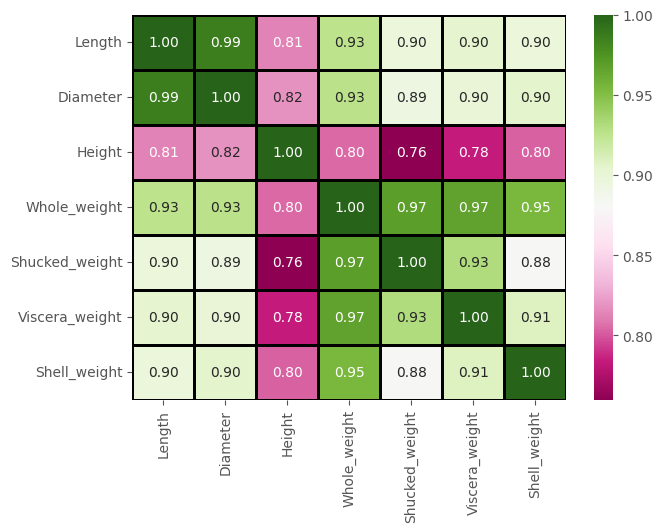

In [19]:
#Initially, all the squares were tiny, so I'm going back into mathplotlib.pyplot to change the figure size first.
plt.figure(figsize=(7,5))

#We don't expect correlation with year or month sold, so I'm letting those go.
sns.heatmap(X_train_numeric.corr(), annot = True, fmt=".2f", cmap = "PiYG", linewidths = 1, linecolor = "black")

Those correlations are all quite high.  It will be a challenge to work with them.  What do the pair plots look like?

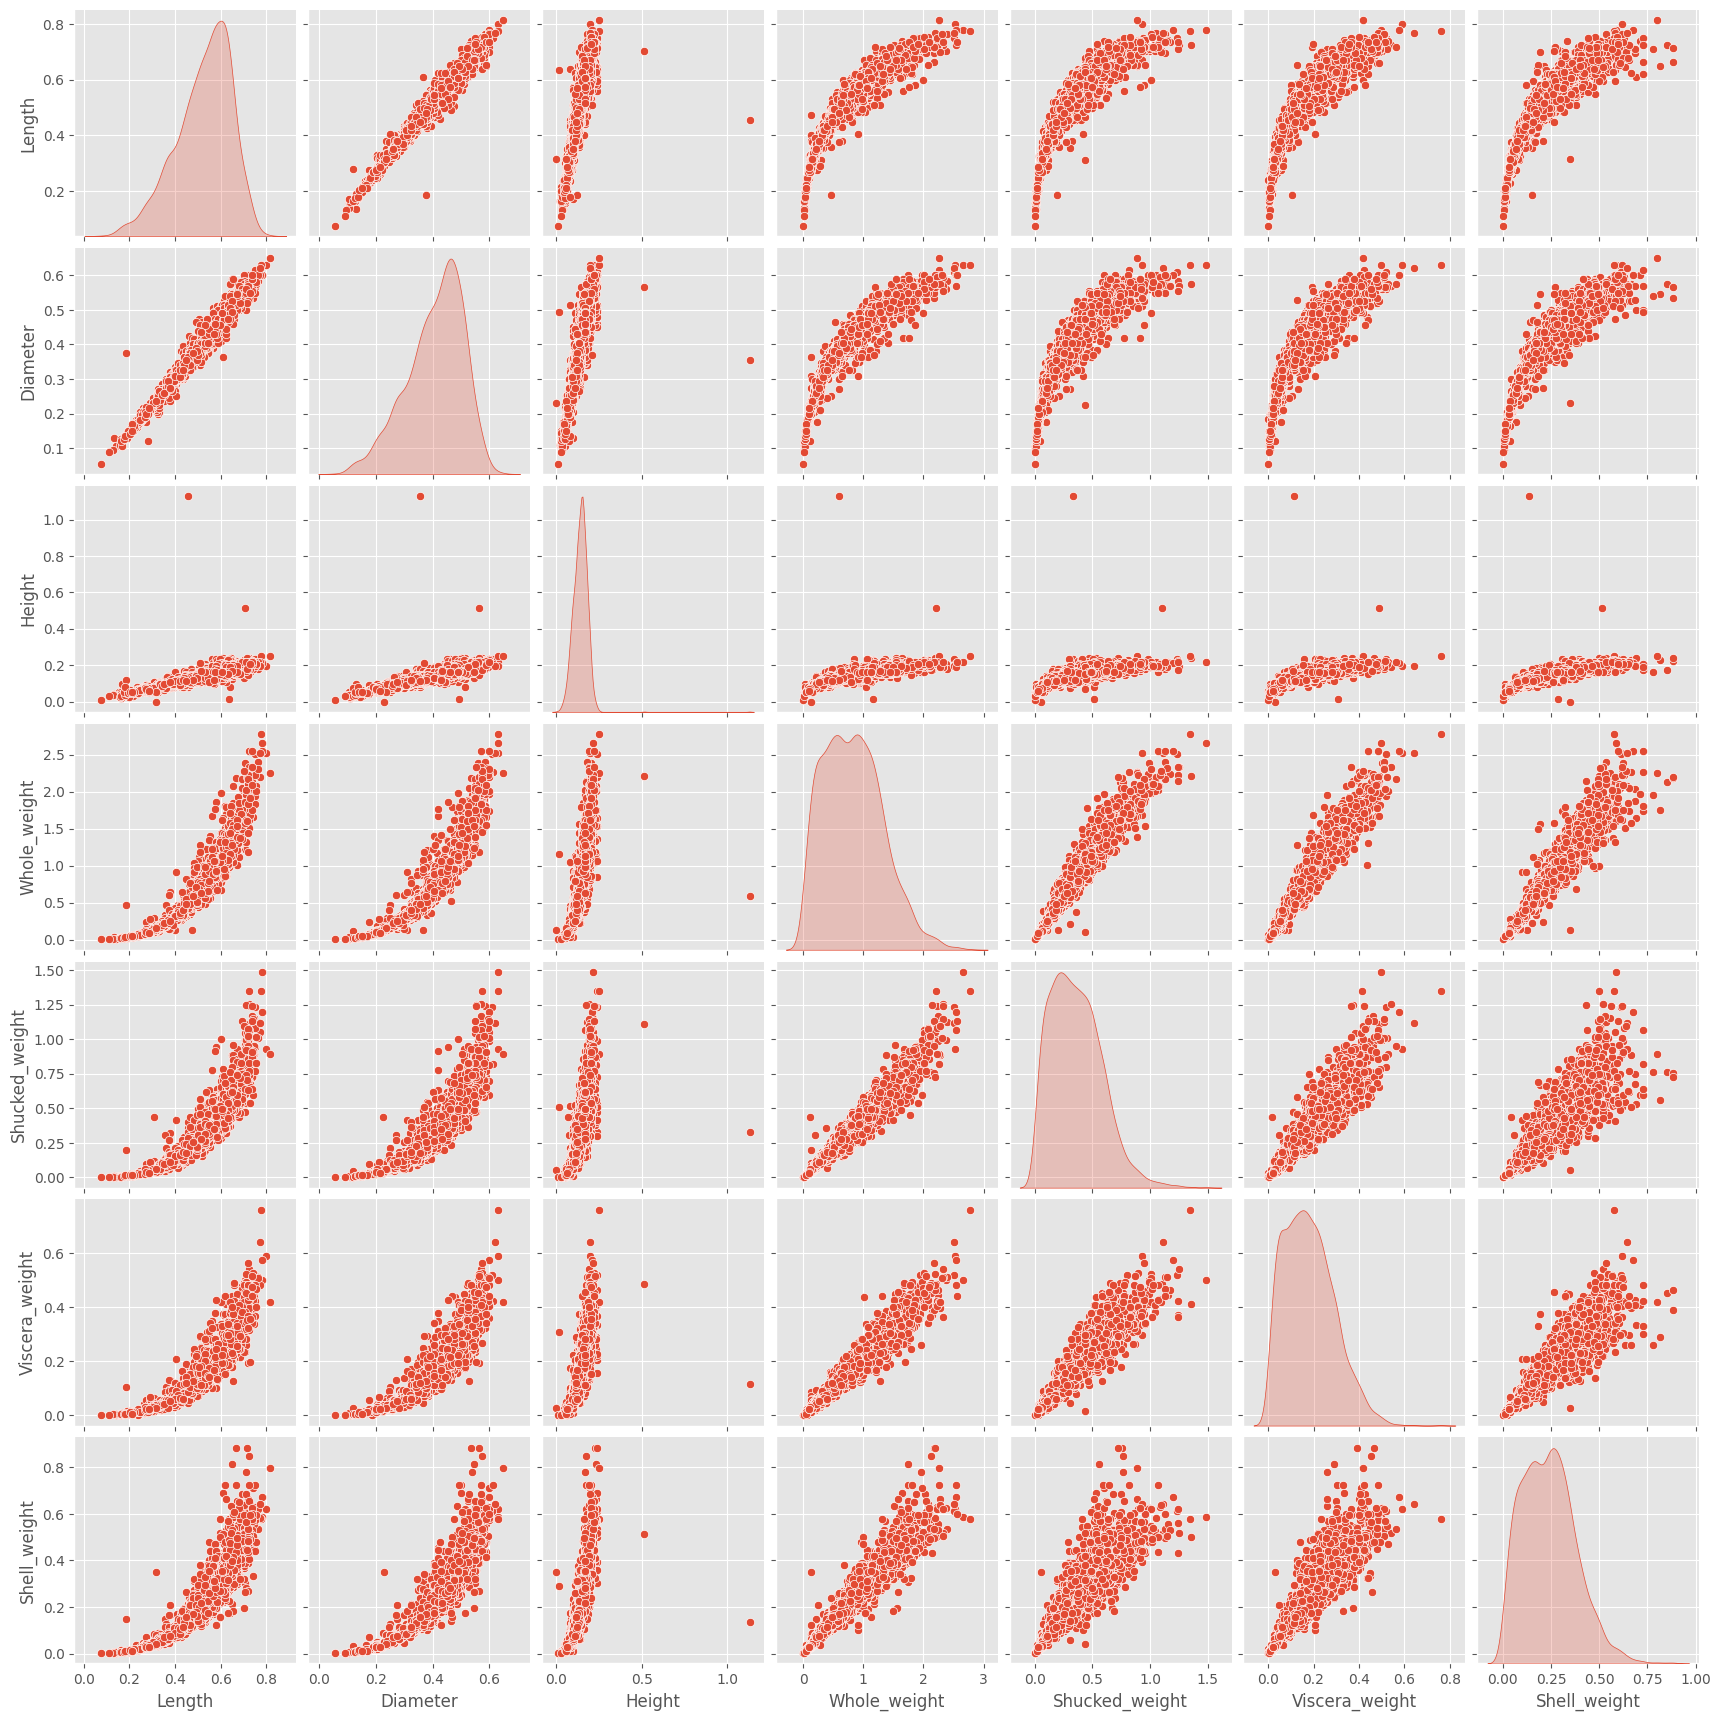

In [12]:
sns.pairplot(X_train_numeric, diag_kind = "kde")

# Other EDA opportunities from the video which I won't use in the project


In [27]:
X_train.head()
y_train.describe()

,Rings
count,3341.000000
mean,9.973960
std,3.261127
min,1.000000
25%,8.000000
50%,10.000000
75%,11.000000
max,27.000000


Let's start with a basic linear regression for baseline scores of accuracy and prediction.  I'm going to use a standard 80/20 split for training and testing at this stage, although I will use cross-validation later.

None of our EDA leads us to think Linear Regression is the best path.  It is going to struggle with I under 'Sex', it is going to struggle with the high correlation between variables.  Nevertheless, it gives us a good baseline for the future methods.

## Linear Regression

Note that I've left off length and sex, because they aren't significant, with p-values of 0.5.  Note that our adjusted R^2 is 0.523

Linear regression is going to have trouble with sex, because of the indeterminate I, but I think trees will be able to deal with this much better.  I'm interested to see what happens.  

In [21]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
df = X_train.copy()
df['Rings'] = y_train
lm = smf.ols('Rings ~ Diameter + Height + Whole_weight + Shucked_weight + Viscera_weight + Shell_weight', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Rings   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     622.4
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:11:32   Log-Likelihood:                -7434.1
No. Observations:                3341   AIC:                         1.488e+04
Df Residuals:                    3334   BIC:                         1.493e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.9121      0.279     10.421      0.000       2.364       3.460
Diameter          12.0461      1.115     10.801      0.000       9.859      14.233
Height            10.4898      1.638      6.405      0.000       7.279      13.701
Whole_weight       8.7990      0.813     10.822      0.000       7.205      10.393
Shucked_weight   -20.1160      0.911    -22.085      0.000     -21.902     -18.330
Viscera_weight    -9.8870      1.467     -6.738      0.000     -12.764      -7.010
Shell_weight      10.0766      1.264      7.974      0.000       7.599      12.554
==============================================================================
Omnibus:                      744.063   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1918.581
Skew:                           1.197   Prob(JB):                         0.00
Kurtosis:                       5.838   Cond. No.                         71.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Maybe polynomial terms or interaction terms would help with the fit?  Let's try those next.

In [23]:
for col_name in X_train.columns:
    f = 'Rings ~ ' + col_name
    lmod1 = smf.ols(formula = f, data = df).fit()
    print(round(lmod1.rsquared_adj,4), col_name , lmod1.rsquared_adj)

0.1936 Sex 0.19356235858194326
0.3043 Length 0.30428361927698244
0.3239 Diameter 0.32389111159318373
0.2962 Height 0.2961994770611247
0.2857 Whole_weight 0.28568852304248293
0.1699 Shucked_weight 0.1699416926501317
0.2482 Viscera_weight 0.2481851211351308
0.391 Shell_weight 0.3909698897145565


## Polynomial Regression
With just the best fitting single, let's look at polynomial regression with a few degrees.  I think it is also worth trying shell_weight and diameter with an interaction term, just to show I know how?

In [24]:
lmod2 = smf.ols(formula = 'Rings ~ Shell_weight + Diameter', data = df).fit()
print(round(lmod2.rsquared_adj,4), 'Shell_weight + Diameter', lmod2.rsquared_adj)

lmod_int = smf.ols(formula = 'Rings ~ Shell_weight* Diameter', data = df).fit()
#print(lmod_int.summary())

lmod_poly = smf.ols(formula = 'Rings ~ Shell_weight + I(Shell_weight**2)', data = df).fit()
#print(lmod_poly.summary())

lmod_poly = smf.ols(formula = 'Rings ~ Shell_weight + I(Shell_weight**2) + I(Shell_weight**3)', data = df).fit()
print(lmod_poly.summary())

0.3909 Shell_weight + Diameter 0.3908556044419277
                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     792.9
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:12:28   Log-Likelihood:                -7790.5
No. Observations:                3341   AIC:                         1.559e+04
Df Residuals:                    3337   BIC:                         1.561e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

I'm not going to do logistic regression, because this is not a binary classification model.  I understand that there are methods to adapt binary classification to features with multiple classes, but I think I have enough going on in this project without that.

KNN should be effective.  I should probably do it, but depending on length I might skip that as well.  I'm quite excited to analyse using decision trees with regression and with with classification.  I'm curious to see what happens when those two methods are compared.

In [ ]:
knnm = KNeighborsClassifier(n_neighbors=14, weights='uniform', 
                                       algorithm='auto', leaf_size=30, p=2, 
                                       metric='minkowski', metric_params=None, n_jobs=None)
knnm.fit(X_train_numeric, y_train)
knnm.score(X_test_numeric, y_test)

c:\Users\eltur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.25717703349282295

Note that KNN isn't doing very well, but might it do better if we normalize the columns?



In [42]:
X_train_norm = (X_train_numeric - X_train_numeric.mean())/X_train_numeric.std()
X_test_norm = (X_test_numeric - X_test_numeric.mean())/X_test_numeric.std()
print(X_train_norm.head())
print(X_train_numeric.head())

        Length  Diameter    Height  Whole_weight  Shucked_weight  \
1440 -0.990558 -1.187954 -1.162151     -1.119560       -1.119033   
2309 -0.449866 -0.332055 -0.226183     -0.511893       -0.656533   
2641 -0.408274 -0.432749 -0.928159     -1.428509       -0.710680   
1820  1.504946  1.379742  0.943777      1.452283        1.116758   
318   0.465153  0.473497  0.358797      0.013933       -0.203058   

      Viscera_weight  Shell_weight  
1440       -0.968990     -1.135697  
2309       -0.153572     -0.318559  
2641       -0.854465     -0.836920  
1820        1.710894      1.621694  
318        -0.387203      0.581373  
      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
1440   0.405     0.290   0.090        0.2825          0.1120          0.0750   
2309   0.470     0.375   0.130        0.5795          0.2145          0.1640   
2641   0.475     0.365   0.100        0.1315          0.2025          0.0875   
1820   0.705     0.545   0.180        1.5395     

In [53]:
knnm_norm = KNeighborsClassifier(n_neighbors=14, weights='uniform', 
                                       algorithm='auto', leaf_size=30, p=3, 
                                       metric='minkowski', metric_params=None, n_jobs=None)
knnm_norm.fit(X_train_norm, y_train)
knnm_norm.score(X_test_norm, y_test)

c:\Users\eltur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.2703349282296651

We could do loops to find the best metric and number of neighbors, but this doesn't seem like the correct path with this data, so I'm not going to.

In [14]:
# Do not run this cell.  I just brought the code over from Module 4 just in case I decided to do some accuracy checks.

acc = []
wacc = []
allks = range(1,21)

# your code here
for i in allks:
    knn = KNN(data.train_x, data.train_y, K=i)
    y_pred = knn.predict(data.val_x)
    acc.append(sklearn.metrics.accuracy_score(data.val_y ,y_pred))
# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,22,2))
ax.grid(alpha=0.25)

NameError: name 'KNN' is not defined

Of course after doing decision trees, I'm going to do some ensemble methods.  I'll just do ensemble on classification OR regression, but I'll wait to make that decision until after I have the results from the individual decision trees.

# Start again here.  First try replacing the strings with numeric values 1,2,3, then try one hot encoding.  There is a built in algorithm.

### DecisionTreeRegressor
class sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0, monotonic_cst=None)

In [15]:
md = 5
mln = 5
clf = DecisionTreeRegressor(max_depth = md, max_leaf_nodes = mln)
trained_DTC = clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'M'

### One hot encoding or ordinal encoding? 
sklearn.preprocessing.OneHotEncoder(categories='auto', drop=None, sparse_output=True, 
                                    dtype=<class 'numpy.float64'>, handle_unknown='error', 
                                    min_frequency=None, max_categories=None, feature_name_combiner='concat') 

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3341 entries, 3416 to 3143
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3341 non-null   object 
 1   Length          3341 non-null   float64
 2   Diameter        3341 non-null   float64
 3   Height          3341 non-null   float64
 4   Whole_weight    3341 non-null   float64
 5   Shucked_weight  3341 non-null   float64
 6   Viscera_weight  3341 non-null   float64
 7   Shell_weight    3341 non-null   float64
dtypes: float64(7), object(1)
memory usage: 234.9+ KB


In [89]:
ohe = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
col_one_hot = ohe.fit_transform(X_train[['Sex']])
ohe.categories_
print(col_one_hot.shape)
print(X_train.shape)
# X_one_hot.categories_
col_to_join = pd.DataFrame(col_one_hot)
print(col_to_join.shape)
# X_one_hot = pd.concat([col_to_join, X_train], axis = 1, ignore_index = True)
X_one_hot = X_train.join(col_to_join)
X_one_hot
# print(col_one_hot)
feature_labels = np.array(ohe.categories_).ravel()
coh = pd.DataFrame(col_one_hot, columns = feature_labels)
print(coh.shape)
coh.reset_index(drop = True, inplace = True)
X_train.reset_index(drop = True, inplace = True)
X_one_hot = pd.concat([X_train.drop(columns = ['Sex']), coh], axis = 1)
X_one_hot

(3341, 3)
(3341, 8)
(3341, 3)
(3341, 3)


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,F,I,M
0,0.560,0.450,0.140,0.9000,0.4720,0.1820,0.2180,0.0,0.0,1.0
1,0.525,0.390,0.135,0.6005,0.2265,0.1310,0.2100,1.0,0.0,0.0
2,0.450,0.355,0.115,0.4385,0.1840,0.1080,0.1125,0.0,1.0,0.0
3,0.650,0.565,0.200,1.6645,0.7530,0.3670,0.4300,1.0,0.0,0.0
4,0.515,0.400,0.125,0.5625,0.2500,0.1245,0.1700,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3336,0.390,0.310,0.100,0.3020,0.1160,0.0640,0.1150,0.0,1.0,0.0
3337,0.495,0.370,0.125,0.4775,0.1850,0.0705,0.1690,0.0,1.0,0.0
3338,0.530,0.415,0.175,0.7395,0.2610,0.1395,0.2645,0.0,0.0,1.0
3339,0.630,0.490,0.160,1.0900,0.4070,0.2240,0.3540,0.0,0.0,1.0


In [ ]:
X_encoded = sklearn.preprocessing.OrdinalEncoder(*, categories='auto', dtype=<class 'numpy.float64'>, 
                                     handle_unknown='error', unknown_value=None, encoded_missing_value=nan, 
                                     min_frequency=None, max_categories=None)

In [92]:
md = 5
mln = 5

dtr = DecisionTreeRegressor(max_depth = md, max_leaf_nodes = mln)
trained_dtf = clf.fit(X_one_hot, y_train)

trained_dtf.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Sex
Feature names seen at fit time, yet now missing:
- F
- I
- M


# Plots to implement when I'm done with the encoding.

In [ ]:
allmaxd = range(2,21)

# your code here
for i in allmaxd:
    model_dt = build_dt(X_train, y_train, max_depth = i)
    y_pred = model_dt.predict(X_test)
    precision.append(calculate_precision(y_test, y_pred))
    recall.append(calculate_recall(y_test, y_pred))
# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allmaxd, precision, marker="o", color="steelblue", lw=3, label="precision")
ax.plot(allmaxd, recall, marker="o", color="red", lw=3, label="recall")
ax.set_xlabel("maximum depth", fontsize=16)
ax.set_ylabel("scores", fontsize=16)
plt.xticks(range(1,22,1))
ax.legend()
ax.grid(alpha=0.25)

In [ ]:
model_dt = build_dt(X_train, y_train, max_leaf_nodes = 4)
y_pred = model_dt.predict(X_test)

print('When max_leaf_nodes = 4, the depth of the tree is 3, the precision is ', calculate_precision(y_test, y_pred),
      'and recall is ', calculate_recall(y_test, y_pred))
sklearn.tree.plot_tree(model_dt)

In [ ]:
allmaxleaf = range(2,21)

# your code here
for i in allmaxleaf:
    model_dt = build_dt(X_train, y_train, max_leaf_nodes = i)
    y_pred = model_dt.predict(X_test)
    precision.append(calculate_precision(y_test, y_pred))
    recall.append(calculate_recall(y_test, y_pred))
# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allmaxleaf, precision, marker="o", color="steelblue", lw=3, label="precision")
ax.plot(allmaxleaf, recall, marker="o", color="red", lw=3, label="recall")
ax.set_xlabel("maximum leaf nodes", fontsize=16)
ax.set_ylabel("scores", fontsize=16)
plt.xticks(range(1,22,1))
ax.legend()
ax.grid(alpha=0.25)

In [ ]:
dt = build_dt(X_train, y_train)

path = dt.cost_complexity_pruning_path(X_train,y_train) #post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities

len(ccp_alphas)

ccp_alphas[np.argmax(test_scores)]

In [ ]:
dt = build_dt(X_train, y_train)

path = dt.cost_complexity_pruning_path(X_train,y_train) #post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = [] # VECTOR CONTAINING CLASSIFIERS FOR DIFFERENT ALPHAS
# TODO: iterate over ccp_alpha values 
# your code here
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# TODO: next, generate the train and test scores and plot the variation in these scores with increase in ccp_alpha
# The code for plotting has been provided; edit the train_scores and test_scores variables for the right plot to be generated
#train_scores = []
#test_scores = []

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]


fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[:130], train_scores[:130], marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas[:130], test_scores[:130], marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show() 

## Random Forests

In [ ]:
RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=None, 
                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                     max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
                     oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, 
                     ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

## SVM 
How do I feel about support vector machines for this data?  I honestly don't know.  Hopefully my EDA (exploratory data analysis) will allow me to determine whether or not it could be valuable to analyze with this method as well.